# Final Exam: Time Series Analysis

## Installing needed packages and setting up data

In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Using cached pystan-3.9.1-py3-none-any.whl.metadata (3.7 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached holidays-0.48-py3-none-any.whl.metadata (23 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached ephem-4.1.5-cp311-cp311-win_amd64.whl.metadata (6.1 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl.metadata (1.6 kB)
INFO: pip is looking at multiple versions of pystan to determine which version is compatible with other requirements. This could take a while.
  Using cached pystan-3.9.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached pystan-3.8.0-py3-none-any.whl.metadata 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
# Setup
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import sys, os
import warnings
warnings.simplefilter(action='ignore')
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

 ## Step 1: Data prep

In [136]:
monthly_co2 = pd.read_csv('./co2from1965to1980.csv.',
                           skipfooter = 2,
                           infer_datetime_format = True,
                          header = 0,
                          index_col = 0,
                          engine = 'python',
                          names = ['month', 'co2'])

monthly_co2.index = pd.to_datetime(monthly_co2.index)

In [137]:
monthly_co2.head()

,co2
month,
1965-01-01,319.32
1965-02-01,320.36
1965-03-01,320.82
1965-04-01,322.06
1965-05-01,322.17


In [138]:
monthly_co2.describe()

,co2
count,192.000000
mean,328.463958
std,5.962682
min,317.250000
25%,323.397500
50%,328.295000
75%,333.095000
max,341.190000


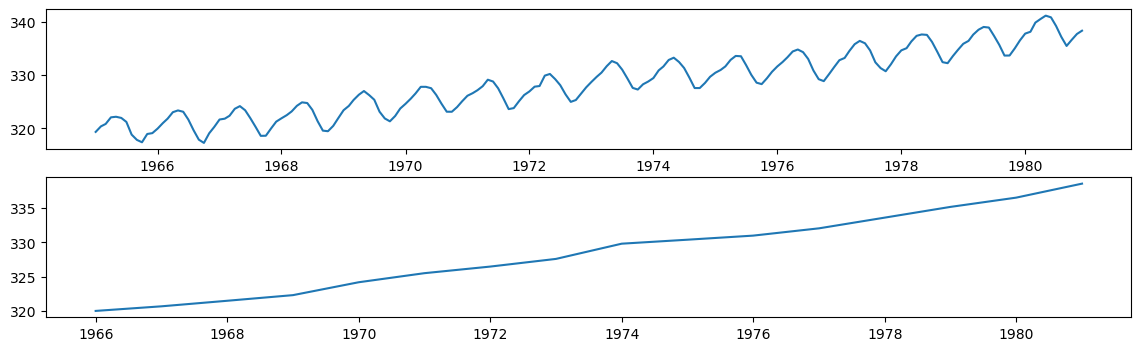

In [139]:
# resample to annual
plt.rcParams['figure.figsize'] = [14, 4]
annual_co2 = monthly_co2.resample('A').mean()
fig, axes = plt.subplots(2,1)
axes[0].plot(monthly_co2)
axes[1].plot(annual_co2)

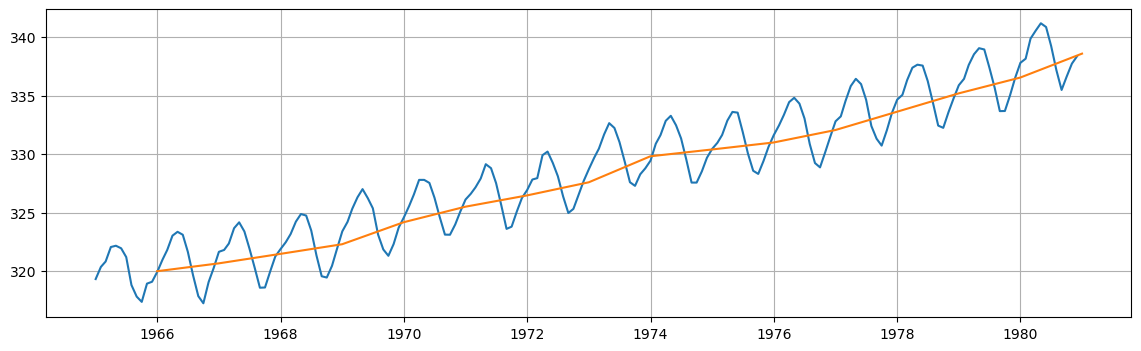

In [140]:
# plot both
plt.plot(monthly_co2)
plt.plot(annual_co2)
plt.grid(True);

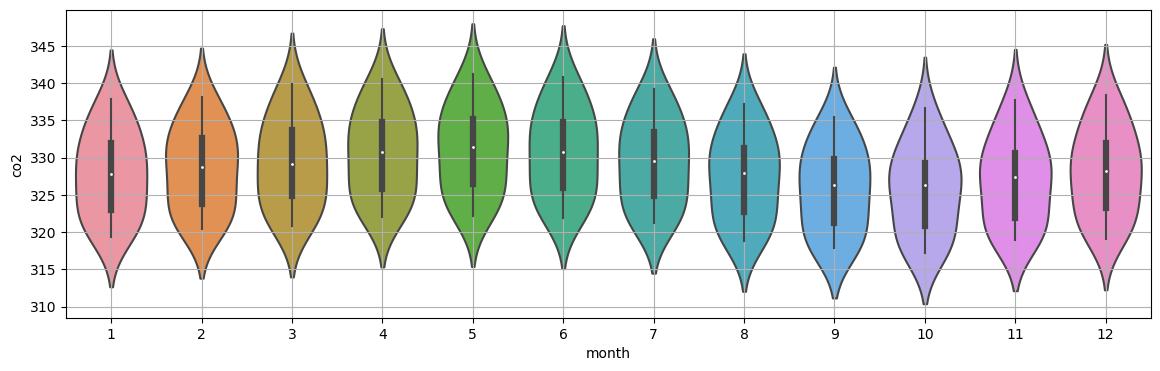

In [141]:
# determine range & variance
sns.violinplot(x = monthly_co2.index.month,
               y = monthly_co2.co2)
plt.grid(True);

In [142]:
 # split into chunks 
chunks = np.split(monthly_co2.co2,
                  indices_or_sections = 12)

In [143]:
mean_vals = np.mean(chunks,
                    axis = 1)
var_vals = np.var(chunks,
                  axis = 1)
vals = {'mean_vals': mean_vals , 'var_vals': var_vals}
mean_var = pd.DataFrame(vals)
mean_var

,mean_vals,var_vals
0,320.353750,2.621036
1,321.341250,4.115686
2,321.623750,4.095611
3,324.668750,3.477686
4,326.278125,3.338553
5,326.868125,3.774053
6,330.165000,2.953850
7,330.938750,3.759973
8,331.355000,4.508300
9,334.186250,3.645836


In [144]:
# define dickey fuller test (dft)
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block = False)

Test Statistic            1.269677
p-value                   0.996434
Lags Used                12.000000
Observations Used       179.000000
Critical Value (1%)      -3.467420
Critical Value (5%)      -2.877826
Critical Value (10%)     -2.575452
dtype: float64


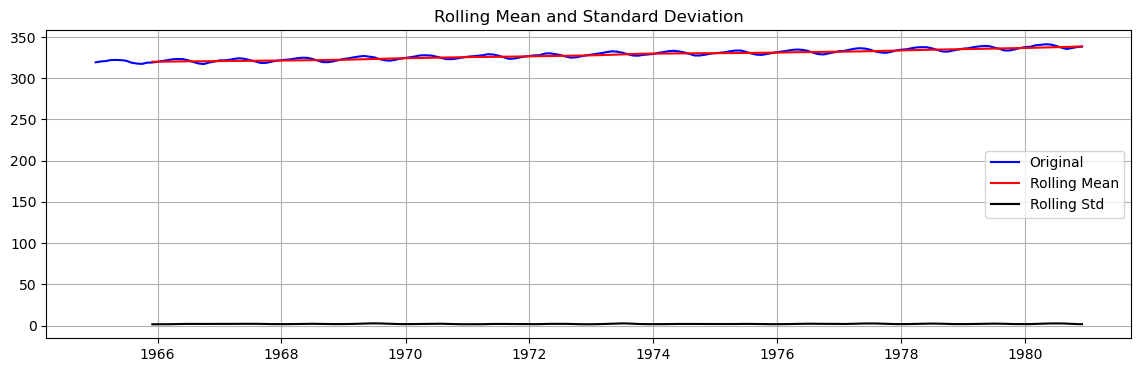

In [146]:
# run dft on monthly then annual
dftest(monthly_co2.co2)

Test Statistic           1.406138
p-value                  0.997142
Lags Used                0.000000
Observations Used       15.000000
Critical Value (1%)     -3.964443
Critical Value (5%)     -3.084908
Critical Value (10%)    -2.681814
dtype: float64


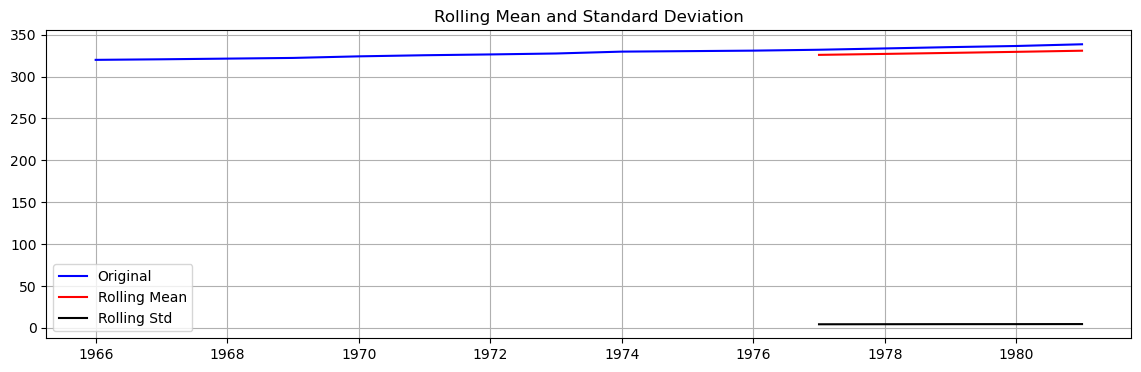

In [147]:
dftest(annual_co2.co2)

Test Statistic          21.829566
p-value                  1.000000
Lags Used                6.000000
Observations Used        9.000000
Critical Value (1%)     -4.473135
Critical Value (5%)     -3.289881
Critical Value (10%)    -2.772382
dtype: float64


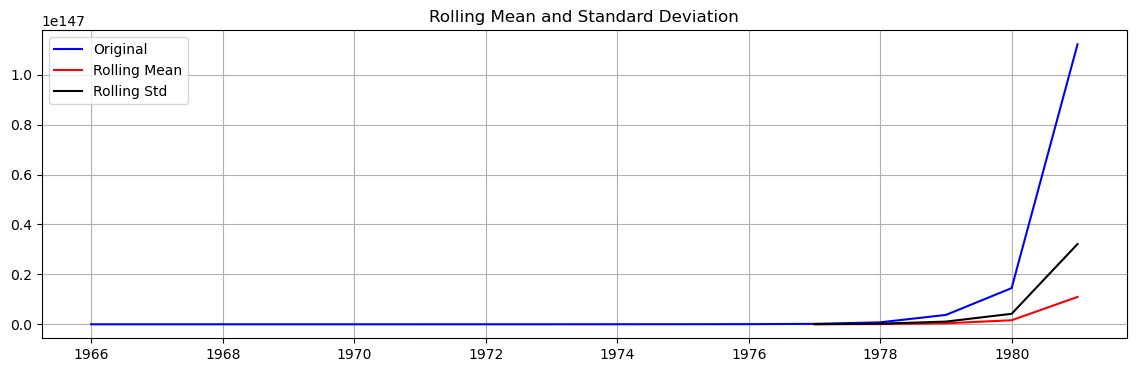

In [148]:
#non stationary
dftest(np.exp(annual_co2.co2))

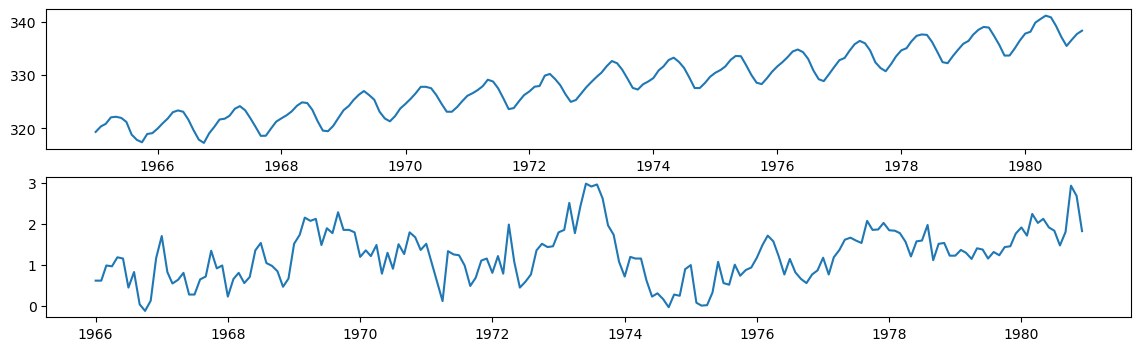

In [149]:
# seasonality

monthly_co2['lag_12'] = monthly_co2.shift(12)
monthly_co2['seasonal_diff'] = monthly_co2.co2 - monthly_co2['lag_12']

fig,axes = plt.subplots(2,1)
axes[0].plot(monthly_co2.co2,label ='original')
axes[1].plot(monthly_co2.seasonal_diff,label = 'seasonal diff')

## Step 2 

In [150]:
# define helper plot function for visualization
def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

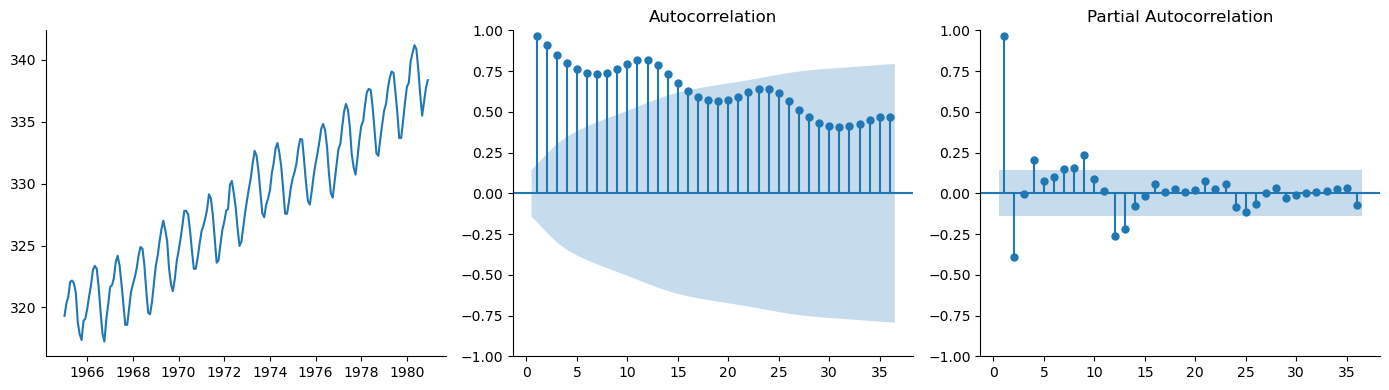

In [151]:
plots(monthly_co2.co2,
     lags = 36)

In [152]:
sar = sm.tsa.statespace.SARIMAX(monthly_co2.co2, 
                                order=(1,0,0), 
                                seasonal_order=(0,1,1,12), 
                                trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  co2   No. Observations:                  192
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 -57.335
Date:                              Tue, 14 May 2024   AIC                            122.669
Time:                                      11:45:45   BIC                            135.441
Sample:                                  01-01-1965   HQIC                           127.848
                                       - 12-01-1980                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1835      0.055      3.320      0.001       0.075       0.292
ar.L1          0.8513      0.045     18.838      0.000       0.763       0.940
ma.S.L12      -0.7875      0.085     -9.260      0.000      -0.954      -0.621
sigma2         0.1032      0.010     10.857      0.000       0.085       0.122
===================================================================================
Ljung-Box (L1) (Q):                   4.19   Jarque-Bera (JB):                19.46
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.41
Prob(H) (two-sided):                  0.81   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

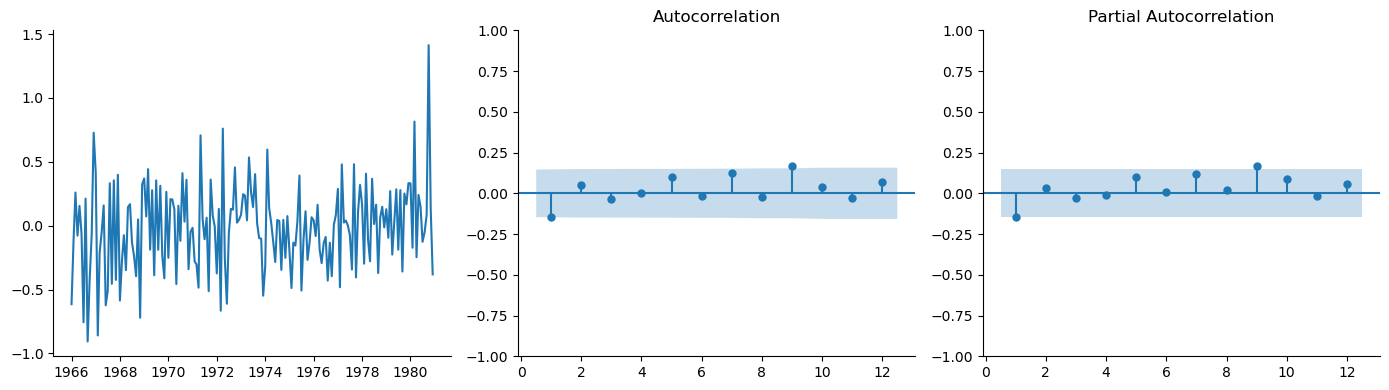

In [158]:
# plot residuals
plots(sar.resid[sar.loglikelihood_burn:],
      lags = 12);

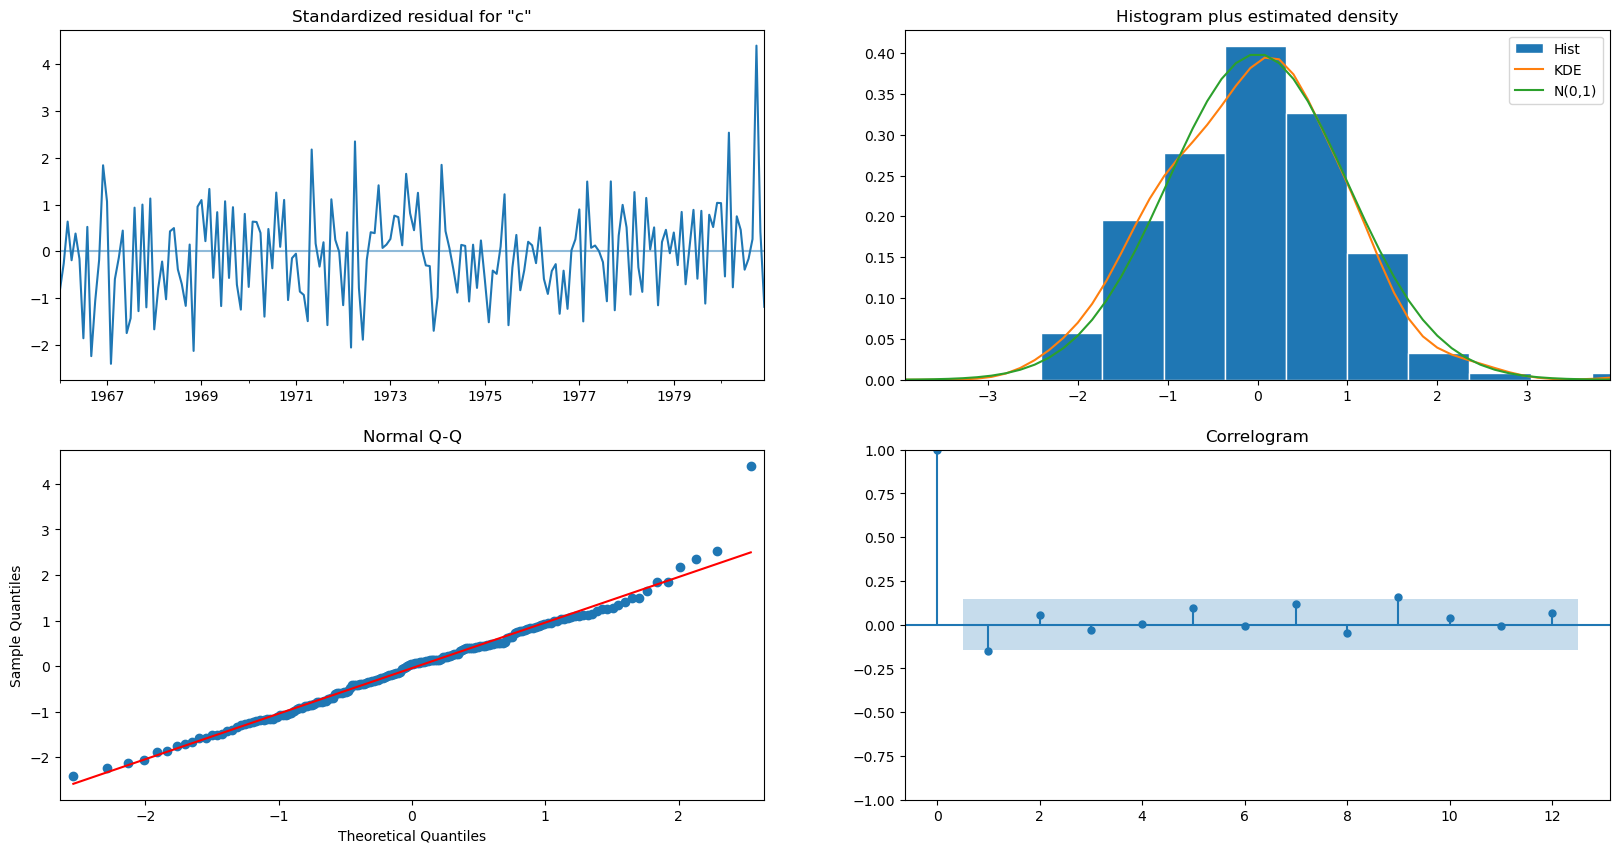

In [159]:
# plot the diagnostics
sar.plot_diagnostics(lags = 12,
                    figsize = (20,10),);

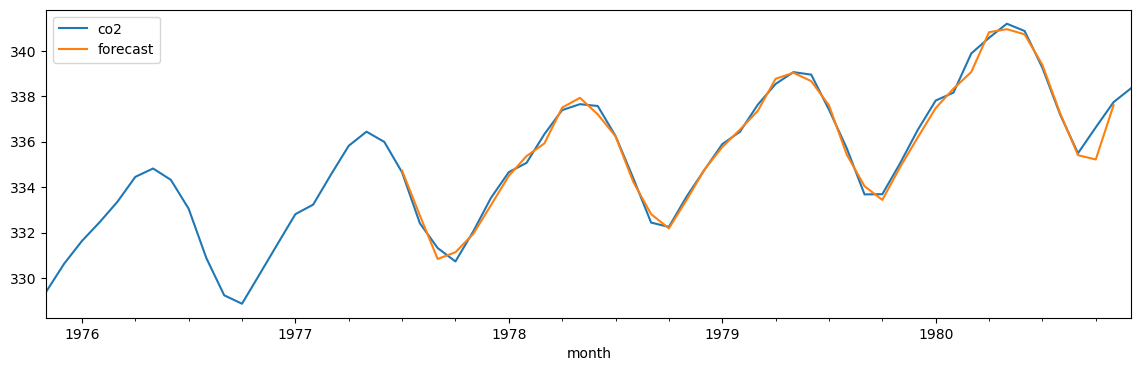

In [160]:
# plot predictions
pd.plotting.register_matplotlib_converters()
monthly_co2['forecast'] = sar.predict(start = 150,
                                     end = 190)
monthly_co2[130:][['co2', 'forecast']].plot();

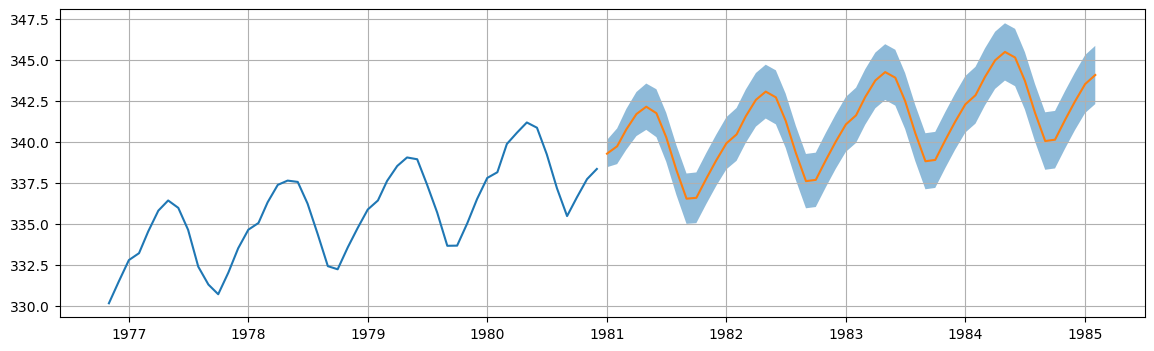

In [161]:
# use forecast to make a forecast object
future_fcst = sar.get_forecast(50)
confidence_int = future_fcst.conf_int(alpha = 0.01)
fcst = future_fcst.predicted_mean
# plot predictions and conf intervals
plt.plot(monthly_co2.co2[-50:])
plt.plot(fcst)
plt.fill_between(confidence_int.index,
                confidence_int['lower co2'],
                confidence_int['upper co2'],
                 alpha = 0.5)
plt.grid()

## Various types of tests

In [162]:
# create and run statistical tests on model
# durbin watson test

norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
lb_val, lb_p = sar.test_serial_correlation(method = 'ljungbox',)[0]
het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]

lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(
    sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=19.460, p=0.000
Ljung-Box: val=35.129, p=0.067
Heteroskedasticity: val=0.940, p=0.812
Durbin-Watson: d=2.29


#### p-value = 0.812 (very good model)

In [163]:
# do a step wise model next. However, They are not too reliant, so be weary when using.

stepwise_model = pm.auto_arima(monthly_co2.co2, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=117.268, Time=0.86 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=351.133, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=134.780, Time=0.82 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=632.188, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=177.055, Time=0.15 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=134.856, Time=0.70 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=122.669, Time=0.72 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=119.372, Time=2.24 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=345.213, Time=0.25 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=179.160, T

In [164]:
from dateutil.relativedelta import relativedelta
def future_preds_df(model, 
                    series,
                    num_months):
    pred_first = series.index.max() + relativedelta(months = 1)
    pred_last = series.index.max() + relativedelta(months = num_months)
    date_range_index = pd.date_range(pred_first,
                                     pred_last,
                                     freq = 'MS')
    vals = model.predict(n_periods = num_months)
    return pd.DataFrame(vals,
                        index = date_range_index)

In [165]:
preds = future_preds_df(stepwise_model,
                       monthly_co2.co2,
                       100)

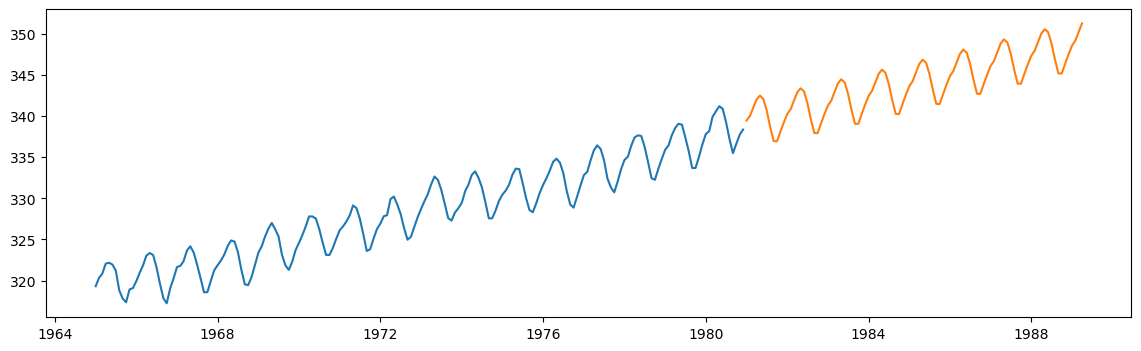

In [166]:
plt.plot(monthly_co2.co2)
plt.plot(preds)

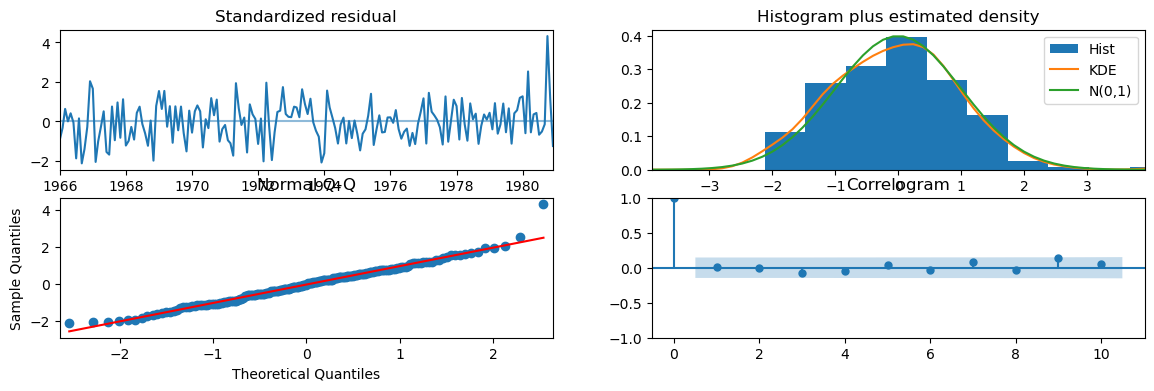

In [167]:
stepwise_model.plot_diagnostics();

In [168]:
print('auto-fit order: :', stepwise_model.order)
print('auto-fit seasonal_order: :', stepwise_model.seasonal_order)

auto-fit order: : (1, 0, 1)
auto-fit seasonal_order: : (0, 1, 1, 12)


In [169]:
# find what model is the worst

def cross_validate(series,
                  horizon,
                  start,
                  step_size,
                  order = (1,0,0),
                  seasonal_order = (0,0,0,0),
                  trend = None):
    
    fcst = []
    actual = []
    date = []
    for i in range(start, len(series) - horizon, step_size):
        model = sm.tsa.statespace.SARIMAX(series[:i+1], #only using data through to and including start 
                                order=order, 
                                seasonal_order=seasonal_order, 
                                trend=trend).fit()
        fcst.append(model.forecast(steps = horizon)[-1]) #forecasting horizon steps into the future
        actual.append(series[i+horizon]) # comparing that to actual value at that point
        date.append(series.index[i+horizon]) # saving date of that value
    return pd.DataFrame({'fcst':fcst,'actual':actual},index=date)

In [170]:
warnings.filterwarnings("ignore")
series = monthly_co2.co2
horizon = 12
start = 100
step_size = 3
order = (1,0,0)
seasonal_order = (0,1,1,12)

cv1 = cross_validate(monthly_temp.temp, 12, 100, 3,
                    order = order,
                    seasonal_order = seasonal_order)

In [171]:
model = sm.tsa.statespace.SARIMAX(series[:101], #only using data through start of 100
                                order=order, 
                                seasonal_order=seasonal_order, 
                                trend=None).fit()

In [172]:
series[:101].tail()

month
1973-01-01    328.73
1973-02-01    329.69
1973-03-01    330.47
1973-04-01    331.69
1973-05-01    332.65
Name: co2, dtype: float64

In [173]:
# value to predict
series[112:113]

month
1974-05-01    333.28
Name: co2, dtype: float64

In [174]:
# what model predicted for that date
model.forecast(12)[-1:]

1974-05-01    333.851473
Freq: MS, Name: predicted_mean, dtype: float64

In [175]:
cv1.head()

,fcst,actual
1974-05-01,333.851473,333.28
1974-08-01,330.627791,329.53
1974-11-01,329.428747,328.53
1975-02-01,331.989144,330.97
1975-05-01,334.364674,333.61


<Axes: title={'center': 'Forecast every 3 months'}>

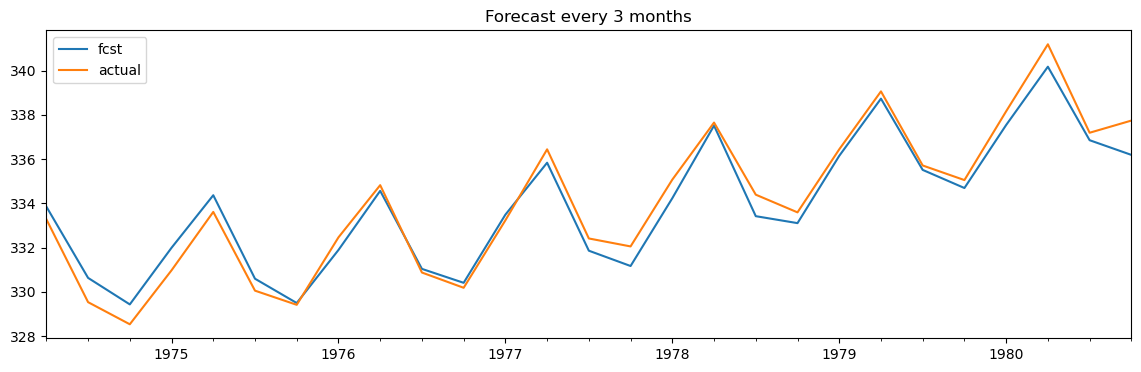

In [176]:
cv1.plot(title = 'Forecast every 3 months')

In [177]:
 # testing out-of sample accuracy
def mape(df_cv):
    return abs(df_cv.actual - df_cv.fcst).sum() / df_cv.actual.sum()

In [178]:
mape(cv1)

0.0017319450867322506

0.173% Indicating it is a very good model fit.

In [179]:
# another

warnings.filterwarnings("ignore")
series = monthly_temp.temp
horizon = 12
start = 100
step_size = 3
order = (1,1,0)
seasonal_order = (0,1,1,12)

cv2 = cross_validate(monthly_temp.temp,12,100,3,
                    order = order,
                    seasonal_order = seasonal_order)

In [180]:
mape(cv2) # 1.63%

0.001630413021763366

In [181]:
len(monthly_co2.co2)

192

In [182]:
def grid_search_ARIMA(series,horizon,start,step_size,orders = [(1,0,0)],seasonal_orders = [(0,0,0,0)],trends=[None]):
    best_mape = np.inf
    best_order = None
    best_seasonal_order = None
    best_trend = None
    for order_ in orders:
        for seasonal_order_ in seasonal_orders:
            for trend_ in trends:
                
                cv = cross_validate(series,
                                    horizon,
                                    start,
                                    step_size,
                                    order = order_,
                                    seasonal_order = seasonal_order_,
                                    trend=trend_)
                if mape(cv)<best_mape:
                    best_mape = mape(cv)
                    best_order = order_
                    best_seasonal_order = seasonal_order_
                    best_trend = trend_
    return (best_order,best_seasonal_order, best_trend, best_mape)

In [183]:
series = monthly_co2.co2
horizon = 12
start = 160
step_size = 3
orders = [(1,1,0), (1,0,0)]
seasonal_orders = [(0,1,1,12)]
trends = [None, 'c']

grid_search_ARIMA(series = series,
                 horizon = horizon,
                 start = start,
                 step_size = step_size,
                 orders = orders,
                 seasonal_orders = seasonal_orders,
                 trends = trends)

((1, 1, 0), (0, 1, 1, 12), 'c', 0.001148247659034364)

0.1148% Indicated the effeciency of the model. The lower the score the better off the model is. Indicating this model is a good fit. 
This model is the best fitted model out of my previous models.